## 数据分析的价值 

在获取数据集之后，进行数据质量分析并查看数据包含哪些信息、是否存在缺失和异常值、不同字段的分布如何、不同特征之间相关性如何，对于思考如何构建更有效的特征至关重要，而这些都需要进行充分的数据分析。本次赛题我们主要有两部分数据：用户对新闻文章的点击日志数据和新闻文章内容数据。以下是对数据进行的一些分析。

In [1]:
# 导包
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

In [2]:
# 数据读取
path = '../download/'

#####train
trn_click = pd.read_csv(path+'train_click_log.csv')
#trn_click = pd.read_csv(path+'train_click_log.csv', names=['user_id','item_id','click_time','click_environment','click_deviceGroup','click_os','click_country','click_region','click_referrer_type'])
item_df = pd.read_csv(path+'articles.csv')
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
item_emb_df = pd.read_csv(path+'articles_emb.csv')

#####test
tst_click = pd.read_csv(path+'testA_click_log.csv')

## 数据字段查看 

In [8]:
# 用户点击日志数据查看
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id_x,created_at_ts_x,words_count_x,category_id_y,created_at_ts_y,words_count_y
0,199999,160417,1507029570190,4,1,17,1,13,1,281,1506942089000,173,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,4,1506994257000,118,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,99,1507013614000,213,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,281,1506983935000,201,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,209,1506938444000,185,209,1506938444000,185


In [6]:
# 字段缺失查看
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 12 columns):
user_id                1112623 non-null int64
click_article_id       1112623 non-null int64
click_timestamp        1112623 non-null int64
click_environment      1112623 non-null int64
click_deviceGroup      1112623 non-null int64
click_os               1112623 non-null int64
click_country          1112623 non-null int64
click_region           1112623 non-null int64
click_referrer_type    1112623 non-null int64
category_id            1112623 non-null int64
created_at_ts          1112623 non-null int64
words_count            1112623 non-null int64
dtypes: int64(12)
memory usage: 110.4 MB


查看结果：用户点击日志数据全部字段均没有缺失

In [9]:
# 训练集统计信息查看
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id_x,created_at_ts_x,words_count_x,category_id_y,created_at_ts_y,words_count_y
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,3.056176e+02,1.506598e+12,2.011981e+02,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.155791e+02,8.343066e+09,5.223881e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,4.100000e+02,1.507756e+12,2.280000e+02,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,4.600000e+02,1.510666e+12,6.690000e+03,4.600000e+02,1.510666e+12,6.690000e+03


In [18]:
# 测试集统计信息查看
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000


In [12]:
# 数据量查看（训练集，测试集）
print('训练集规模:',trn_click['user_id'].nunique())
print('训练集规模:',tst_click['user_id'].nunique())

训练集规模: 200000
训练集规模: 50000


### 数据预处理


计算用户点击rank和点击次数 

In [14]:
# 用户点击行为按时间排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)

In [15]:
#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [20]:
# 新闻文章数据查看
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


In [22]:
# 不同字数文章数量查看
item_df['words_count'].value_counts()

176     3485
182     3480
179     3463
178     3458
174     3456
183     3432
184     3427
173     3414
180     3403
177     3391
170     3387
187     3355
169     3352
185     3348
175     3346
181     3330
186     3328
189     3327
171     3327
172     3322
165     3308
188     3288
167     3269
190     3261
192     3257
168     3248
193     3225
166     3199
191     3182
194     3164
        ... 
601        1
857        1
1977       1
1626       1
697        1
1720       1
696        1
706        1
592        1
1605       1
586        1
582        1
1606       1
972        1
716        1
584        1
1608       1
715        1
841        1
968        1
964        1
587        1
1099       1
1355       1
711        1
845        1
710        1
965        1
847        1
1535       1
Name: words_count, Length: 866, dtype: int64

In [24]:
# 文章数据规模查看
item_df.shape

(364047, 4)

In [25]:
# 新闻文章embedding向量表示
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [26]:
item_emb_df.shape

(364047, 251)

## 数据可视化分析 

#### 查看被点击新闻文章的属性分布

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

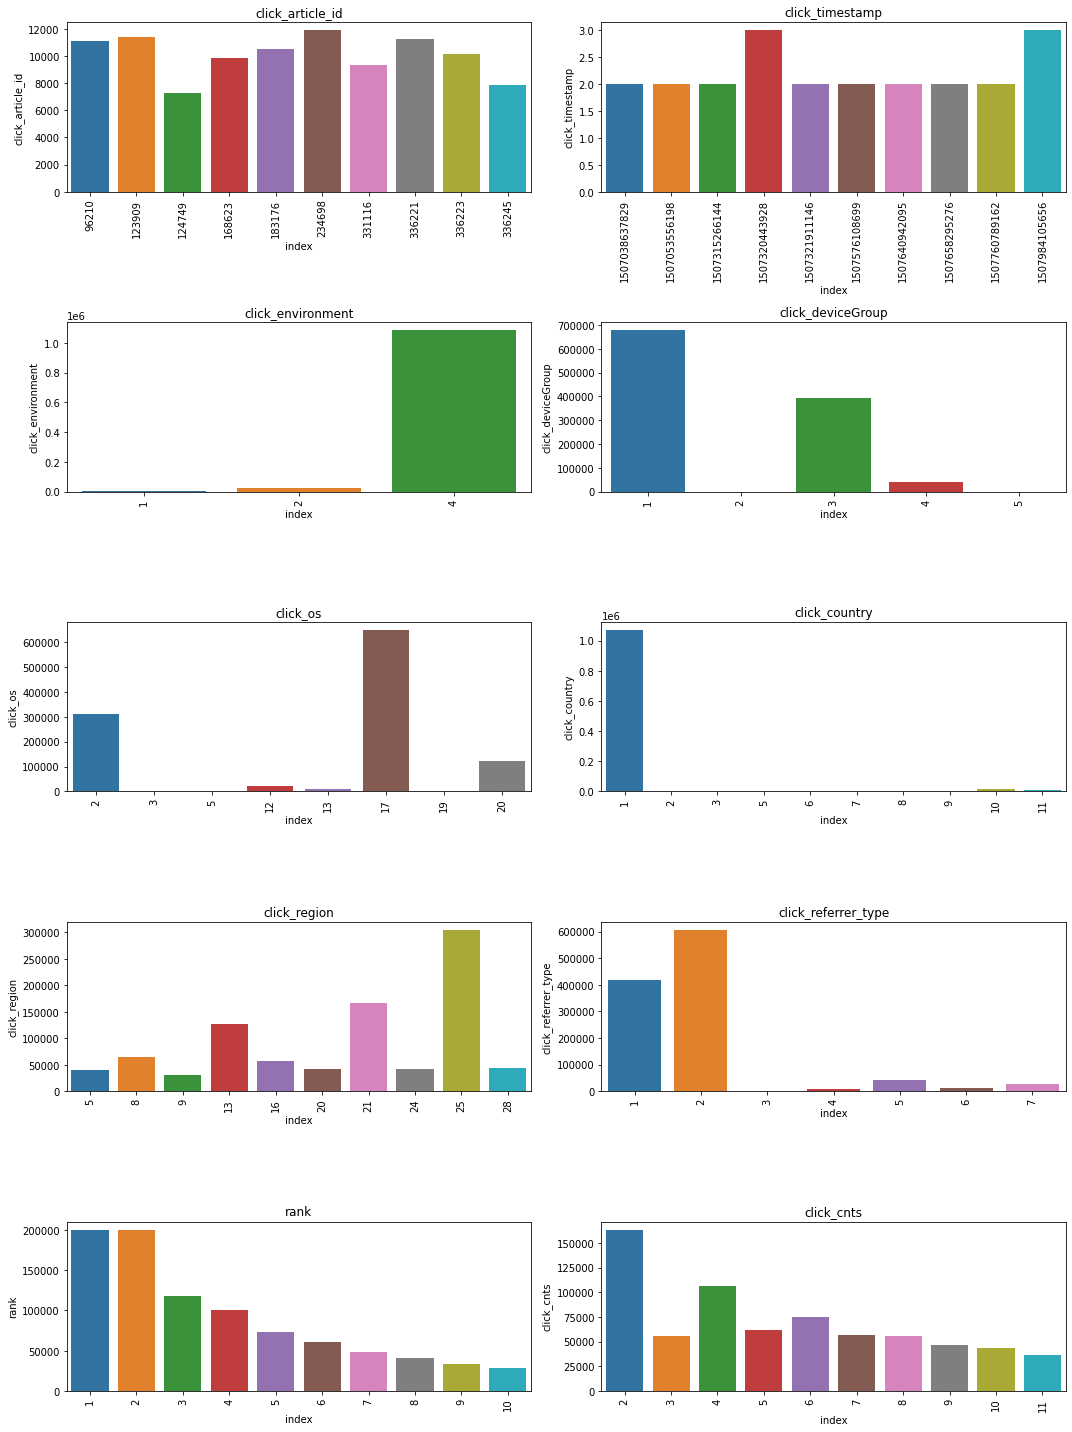

In [16]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

不同文章的点击次数处于同一量级，点击时段分布也较为平均，不需要做特殊处理。

点击环境click_environment的分布差异明显，约有97.6%的点击环境为4，点击环境为1和2的占比仅为2.4%。

点击设备click_deviceGroup为设备1的占比接近60.4%，设备3占比36%。

点击区域click_region中，编号21和25的区域点击次数最多。

#### 查看被点击的新闻文章主题分布

461


<AxesSubplot:>

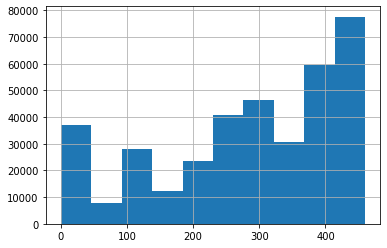

In [23]:
print(item_df['category_id'].nunique())     # 461个文章主题
item_df['category_id'].hist()

#### 用户每篇文章点击次数分析

In [27]:
user_click_merge = trn_click.append(tst_click)
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count['count'].unique()

array([ 1,  2,  4,  3,  6,  5, 10,  7, 13])

分析发现，用户点击同一篇新闻文章的次数最多达到13次

#### 用户点击环境变化分析 

<Figure size 432x288 with 0 Axes>

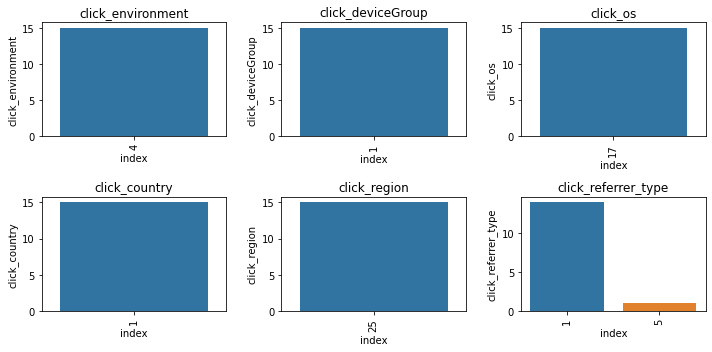

<Figure size 432x288 with 0 Axes>

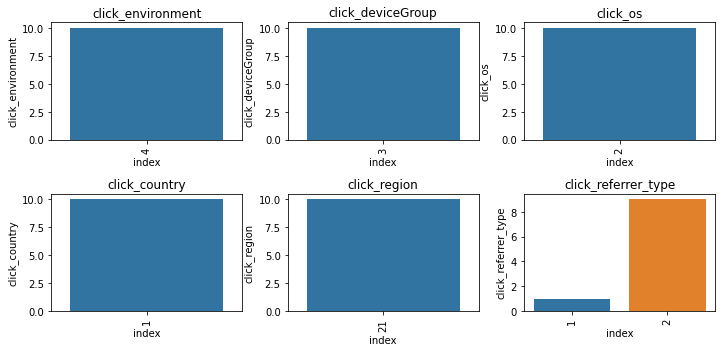

<Figure size 432x288 with 0 Axes>

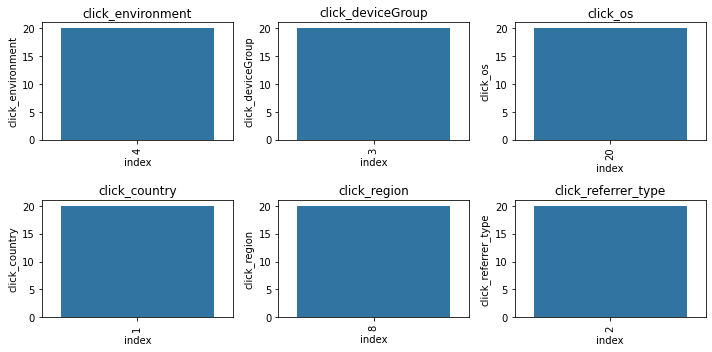

<Figure size 432x288 with 0 Axes>

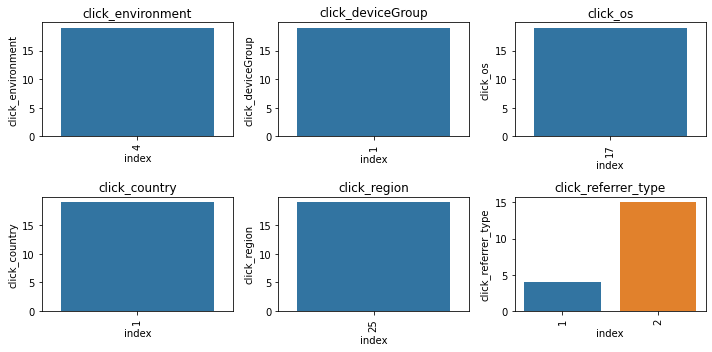

<Figure size 432x288 with 0 Axes>

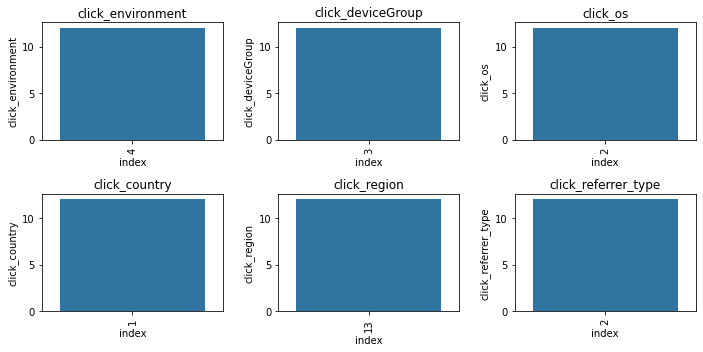

<Figure size 432x288 with 0 Axes>

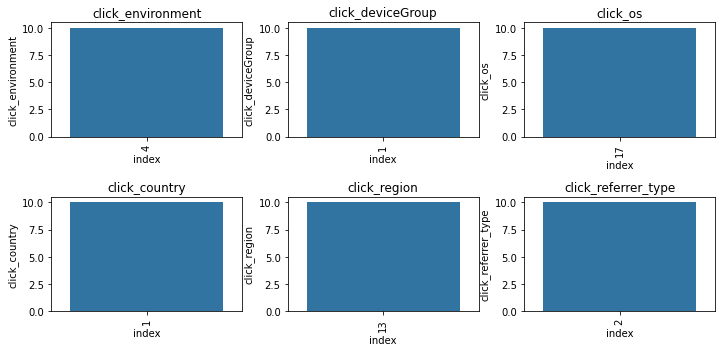

<Figure size 432x288 with 0 Axes>

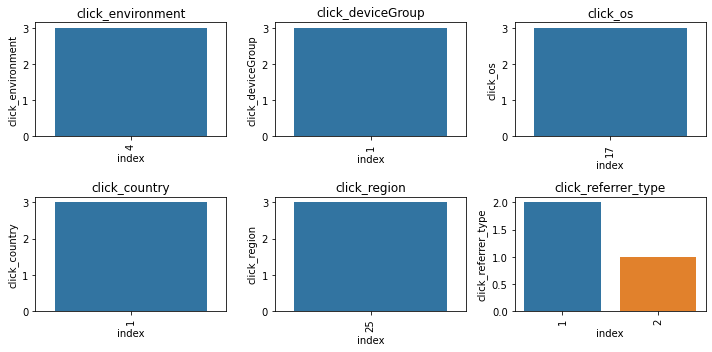

<Figure size 432x288 with 0 Axes>

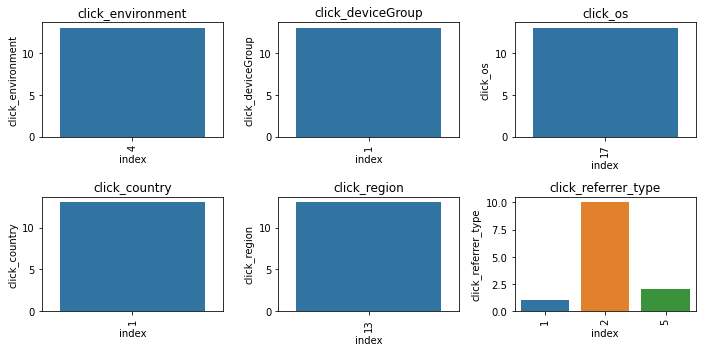

<Figure size 432x288 with 0 Axes>

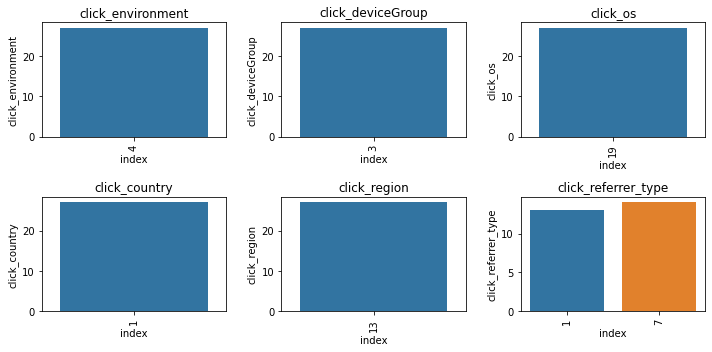

<Figure size 432x288 with 0 Axes>

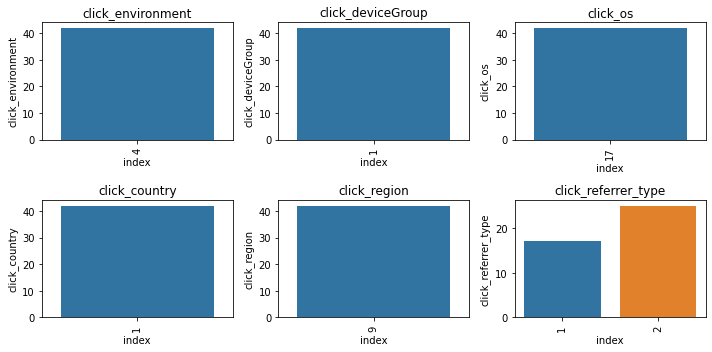

In [28]:
def plot_envs(df, cols, r, c):
    plt.figure()
    plt.figure(figsize=(10, 5))
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index()
        fig = sns.barplot(x=v['index'], y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

    
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=10, replace=False)
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)

图中结果显示：绝大多数数的用户的点击环境是比较固定的。思路：可以基于这些环境的统计特征来代表该用户本身的属性

#### 用户点击新闻数量的分布 

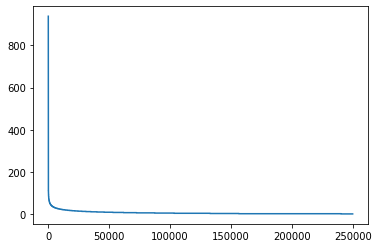

In [29]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count)

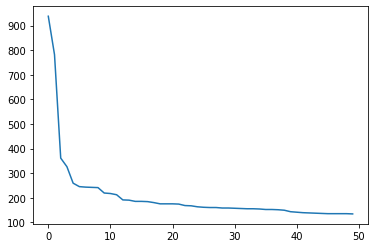

In [30]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

点击次数是用户活跃度的体现指标，排名前50的用户点击次数均超过100次

#### 新闻点击次数分析

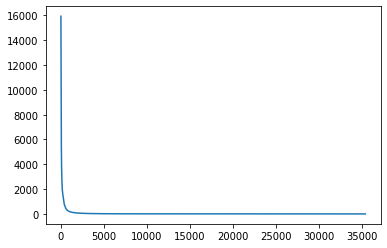

In [31]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)
plt.plot(item_click_count)

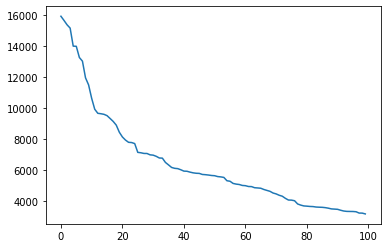

In [32]:
plt.plot(item_click_count[:100])


可以看出点击次数最多的前100篇新闻，点击次数大于4000次

#### 新闻共现频次：两篇新闻连续出现的次数
 

In [33]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


由统计数据可以看出，平均共现次数3.18，最高为2202。

说明用户看的新闻，相关性是比较强的。

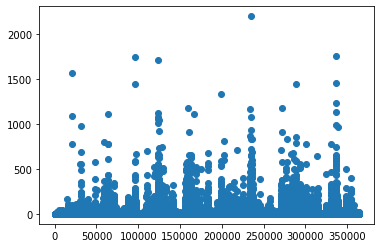

In [34]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)

#### 新闻文章信息

In [35]:
#不同类型的新闻出现的次数
plt.plot(user_click_merge['category_id'].value_counts().values)

KeyError: 'category_id'

In [36]:
#新闻字数的描述性统计
user_click_merge['words_count'].describe()

KeyError: 'words_count'

In [37]:
plt.plot(user_click_merge['words_count'].values)

KeyError: 'words_count'

#### 用户点击的新闻类型的偏好 

In [38]:
plt.plot(sorted(user_click_merge.groupby('user_id')['category_id'].nunique(), reverse=True))

KeyError: 'Column not found: category_id'